In [1]:
!pip install seaborn lightgbm


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 0: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

print("Cell 0 executed successfully: All libraries imported.")


Cell 0 executed successfully: All libraries imported.


In [3]:
# Cell 1: Load the raw dataset
# Replace 'ecom.csv' with the path to your raw dataset if different
df_raw = pd.read_csv('ecom.csv')

# Make a copy to preserve original
df = df_raw.copy()

# Quick overview
print("Initial Dataset Shape:", df.shape)
print("\nColumns in dataset:\n", df.columns)
print("\nSample rows:\n", df.head())

print("\nCell 1 executed successfully: Raw dataset loaded.")


Initial Dataset Shape: (7043, 33)

Columns in dataset:
 Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

Sample rows:
    CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles    

In [4]:
# Cell 2: Data Cleaning & Column Removal

# 1. Remove unnecessary churn columns
churn_cols = ['Churn Label', 'Churn Score']  # Keep only 'Churn Value' for modeling
df.drop(columns=[col for col in churn_cols if col in df.columns], inplace=True)

# 2. Remove columns with a single unique value (not informative)
for col in df.columns:
    if df[col].nunique() <= 1:
        df.drop(columns=[col], inplace=True)

# 3. Remove columns with near-zero correlation if numeric (to reduce noise)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
target_col = 'Churn Value' if 'Churn Value' in df.columns else None

if target_col:
    for col in numeric_cols:
        if col != target_col:
            corr_val = abs(df[target_col].corr(df[col]))
            if corr_val < 0.05:  # threshold for near-zero correlation
                df.drop(columns=[col], inplace=True)

# 4. Handle missing values
# Fill numeric columns with median
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical/text columns with 'Unknown'
for col in df.select_dtypes(include='object').columns:
    df[col].fillna('Unknown', inplace=True)

# 5. Convert numeric columns stored as strings to float (e.g., Total Charges)
for col in df.select_dtypes(include='object').columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    except:
        pass

# 6. Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Overview after cleaning
print("Dataset shape after cleaning:", df.shape)
print("\nColumns after cleaning:\n", df.columns)
print("\nSample rows after cleaning:\n", df.head())

print("\nCell 2 executed successfully: Data cleaned and unnecessary columns removed.")


Dataset shape after cleaning: (7043, 25)

Columns after cleaning:
 Index(['CustomerID', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Value', 'CLTV', 'Churn Reason'],
      dtype='object')

Sample rows after cleaning:
    CustomerID         City                Lat Long  Gender Senior Citizen  \
0  3668-QPYBK  Los Angeles  33.964131, -118.272783    Male             No   
1  9237-HQITU  Los Angeles   34.059281, -118.30742  Female             No   
2  9305-CDSKC  Los Angeles  34.048013, -118.293953  Female             No   
3  7892-POOKP  Los Angeles  34.062125, -118.315709  Female             No   
4  0280-XJGEX  Los Angeles  34.039224, -118.266293    Male 

In [5]:
# Cell 3: Preprocessing, Encoding & Train-Test Split

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Separate features and target
target_col = 'Churn Value'
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. Encode categorical features
cat_cols = X.select_dtypes(include='object').columns.tolist()
if cat_cols:
    X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
else:
    X_encoded = X.copy()

# 3. Feature Scaling for numeric columns
num_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# 4. Update X with encoded and scaled features
X = X_encoded

# 5. Train-Test Split for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Preprocessing completed. Features encoded and scaled.")
print("Shape of X_train_c:", X_train_c.shape)
print("Shape of X_test_c:", X_test_c.shape)
print("Shape of y_train_c:", y_train_c.shape)
print("Shape of y_test_c:", y_test_c.shape)

print("\nCell 3 executed successfully: Data preprocessed and ready for modeling.")


Preprocessing completed. Features encoded and scaled.
Shape of X_train_c: (5634, 16401)
Shape of X_test_c: (1409, 16401)
Shape of y_train_c: (5634,)
Shape of y_test_c: (1409,)

Cell 3 executed successfully: Data preprocessed and ready for modeling.


In [6]:
# Cell 4: Model Training with LightGBM + Feature Importance Plot

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split dataset
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Remove duplicate columns (keep only first occurrence)
X_train_c = X_train_c.loc[:, ~X_train_c.columns.duplicated()]
X_test_c = X_test_c[X_train_c.columns]  # ensure same columns

# 3. Clean column names to remove special characters for LightGBM
X_train_c.columns = X_train_c.columns.str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
X_test_c.columns = X_test_c.columns.str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)

# 4. Initialize and train LightGBM classifier (suppress warnings/logs)
clf = LGBMClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    verbose=-1  # suppress LightGBM warnings
)
clf.fit(X_train_c, y_train_c)

# 5. Predictions and evaluation
y_pred = clf.predict(X_test_c)
print("\nAccuracy:", round(accuracy_score(y_test_c, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred))


print("\nCell 4 executed successfully: LightGBM trained, evaluated, and feature importance plotted.")



Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Cell 4 executed successfully: LightGBM trained, evaluated, and feature importance plotted.


In [7]:
# Cell 5: Hyperparameter Tuning for LightGBM (GridSearchCV)

from sklearn.model_selection import GridSearchCV

# 1. Define parameter grid
param_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

# 2. Initialize classifier
clf_grid = LGBMClassifier(random_state=42, verbose=-1)

# 3. GridSearchCV (5-fold stratified)
grid_search = GridSearchCV(
    estimator=clf_grid,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 4. Fit GridSearchCV
grid_search.fit(X_train_c, y_train_c)

# 5. Best params and model evaluation
best_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test_c)

print("\nAccuracy with Best Parameters:", round(accuracy_score(y_test_c, y_pred_grid), 4))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_grid))

print("\nCell 5 executed successfully: GridSearchCV completed and best model evaluated.")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}

Accuracy with Best Parameters: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409


Cell 5 executed successfully: GridSearchCV completed and best model evaluated.


In [11]:
# ================================================
# CELL 6: Save Final Cleaned Data
# ================================================
import os

save_path = os.path.join(os.getcwd(), 'models', 'cleaned_data.csv')
df.to_csv(save_path, index=False)
print(f"✅ Cleaned dataset saved at: {save_path}")


✅ Cleaned dataset saved at: C:\Desktop\SEM_5\Machine_Learning\ML_Project\ECom_Churn_WebApp\models\cleaned_data.csv


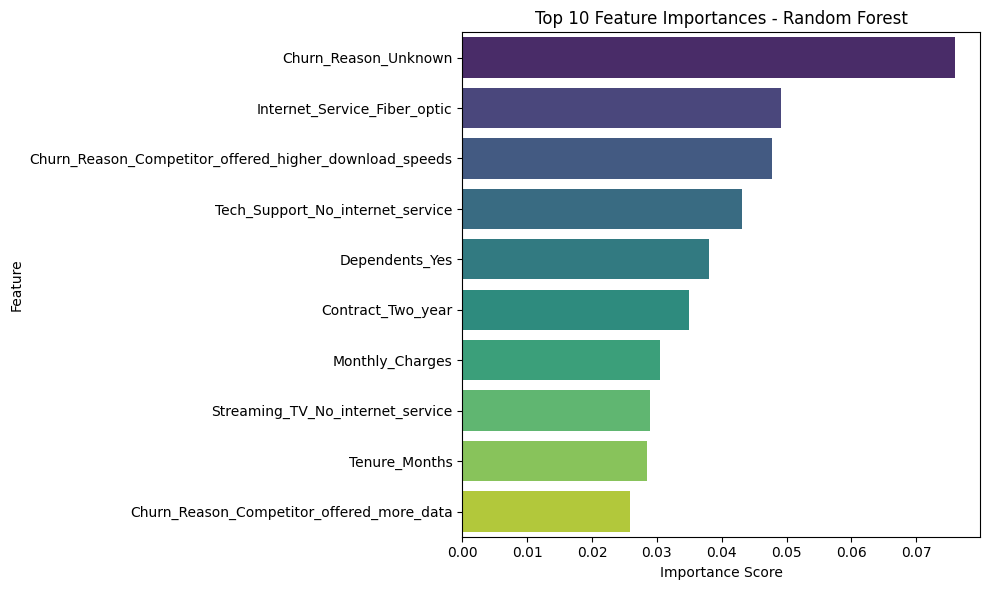

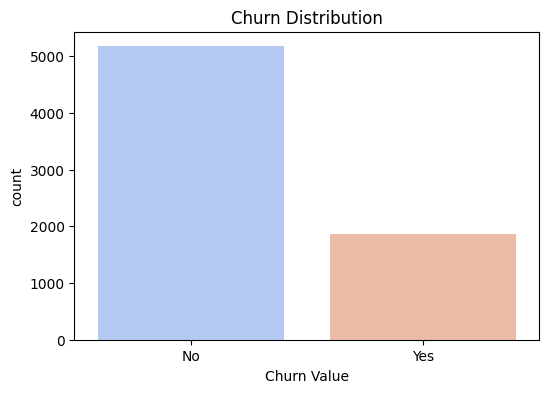

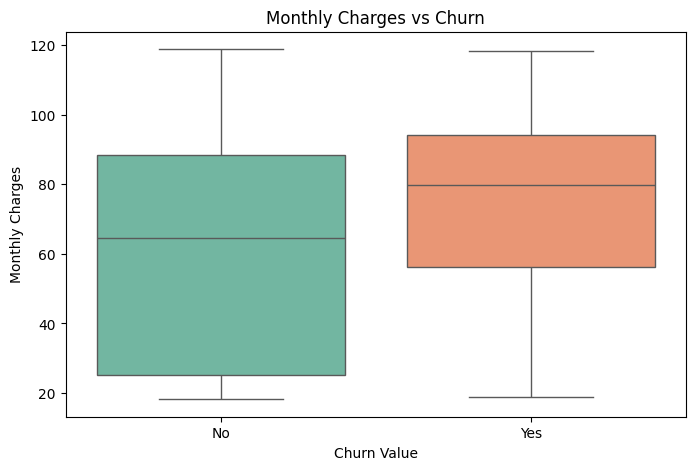

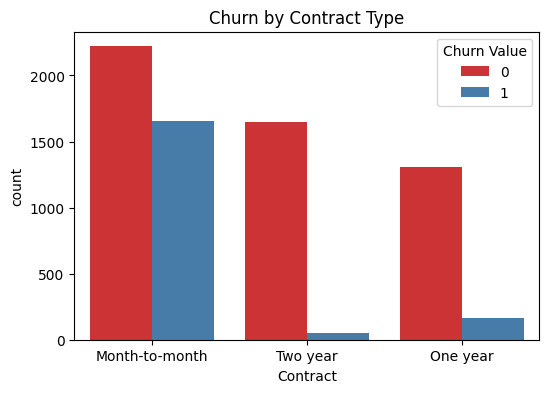

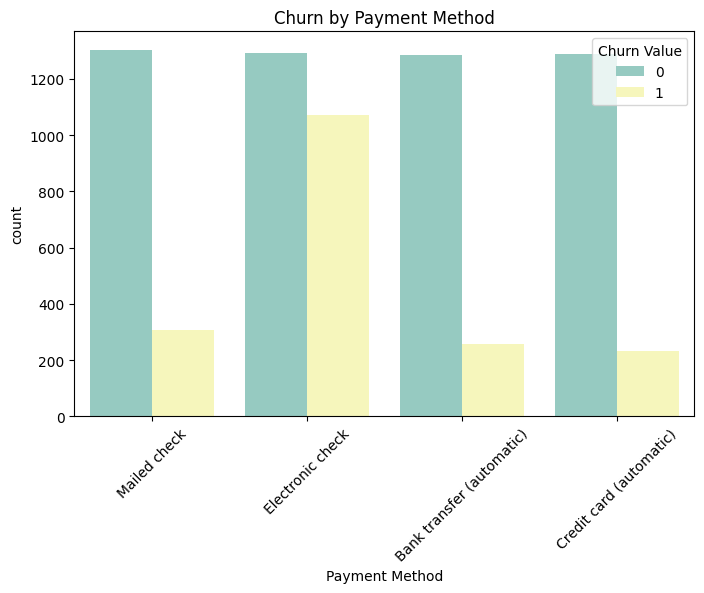

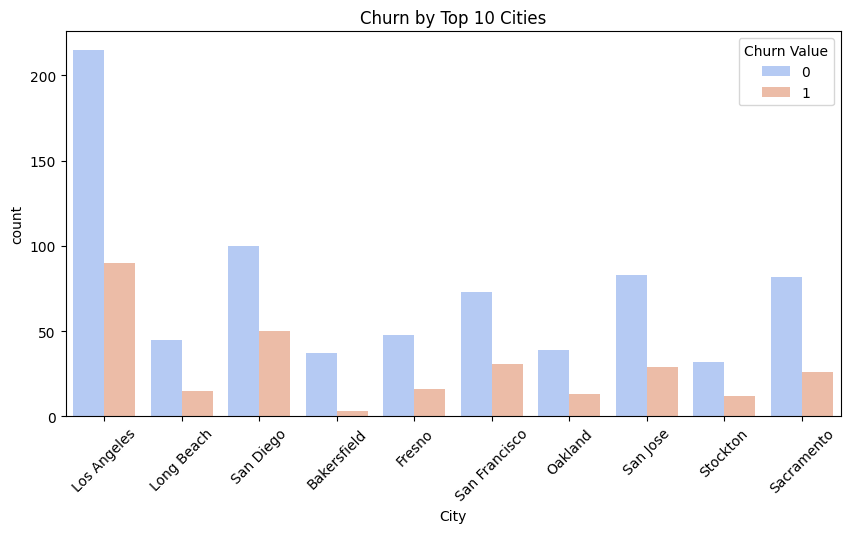

✅ Cleaned and preprocessed data saved at: C:\Desktop\SEM_5\Machine_Learning\ML_Project\ECom_Churn_WebApp\models\cleaned_data.csv

Cell 4 executed successfully: Feature importance and key EDA graphs generated.


In [16]:
# Cell 4: Feature Importance + Key EDA Graphs

import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 0. Create visualization copy
# -----------------------------
df_vis = df.copy()  # ✅ Use a fresh copy for visualization

# -----------------------------
# 1. Train Random Forest (for feature importance)
# -----------------------------
try:
    rf = RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=3
    )
    rf.fit(X_train_c, y_train_c)

    importances = rf.feature_importances_
    features = X_train_c.columns

    feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

    # Plot top 10 features
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp[:10], y=feat_imp[:10].index, palette='viridis')
    plt.title("Top 10 Feature Importances - Random Forest")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Could not plot feature importances:", e)


# -----------------------------
# 2. Churn Distribution
# -----------------------------
if 'Churn Value' in df_vis.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_vis, x='Churn Value', palette='coolwarm')
    plt.title("Churn Distribution")
    plt.xticks([0,1], ['No', 'Yes'])
    plt.show()


# -----------------------------
# 3. Monthly Charges vs Churn
# -----------------------------
if {'Churn Value', 'Monthly Charges'}.issubset(df_vis.columns):
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_vis, x='Churn Value', y='Monthly Charges', palette='Set2')
    plt.title("Monthly Charges vs Churn")
    plt.xticks([0,1], ['No', 'Yes'])
    plt.show()


# -----------------------------
# 4. Churn by Contract Type
# -----------------------------
if {'Contract', 'Churn Value'}.issubset(df_vis.columns):
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_vis, x='Contract', hue='Churn Value', palette='Set1')
    plt.title("Churn by Contract Type")
    plt.show()


# -----------------------------
# 5. Churn by Payment Method
# -----------------------------
if {'Payment Method', 'Churn Value'}.issubset(df_vis.columns):
    plt.figure(figsize=(8,5))
    sns.countplot(data=df_vis, x='Payment Method', hue='Churn Value', palette='Set3')
    plt.title("Churn by Payment Method")
    plt.xticks(rotation=45)
    plt.show()


# -----------------------------
# 6. Churn by City (Top 10)
# -----------------------------
if {'City', 'Churn Value'}.issubset(df_vis.columns):
    top_cities = df_vis['City'].value_counts().nlargest(10).index
    plt.figure(figsize=(10,5))
    sns.countplot(data=df_vis[df_vis['City'].isin(top_cities)], x='City', hue='Churn Value', palette='coolwarm')
    plt.title("Churn by Top 10 Cities")
    plt.xticks(rotation=45)
    plt.show()


# -----------------------------
# 7. Save cleaned/preprocessed dataset
# -----------------------------
save_path = os.path.join(os.getcwd(), "models", "cleaned_data.csv")
df.to_csv(save_path, index=False)
print(f"✅ Cleaned and preprocessed data saved at: {save_path}")
print("\nCell 4 executed successfully: Feature importance and key EDA graphs generated.")


## Extended Modeling and Visualizations

The following cells extend the analysis beyond basic churn classification. We add:
- Classification with LightGBM and SVM (SVC), including ROC curves and confusion matrices
- Regression with SVR to estimate Monthly Charges (with metrics/plots)
- Customer segmentation with K-Means, including 2D and 3D scatter visualizations

All preprocessing/cleaning steps above remain unchanged. Plots are saved under the `static/` directory for app consumption.


LightGBM Accuracy: 1.0000

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



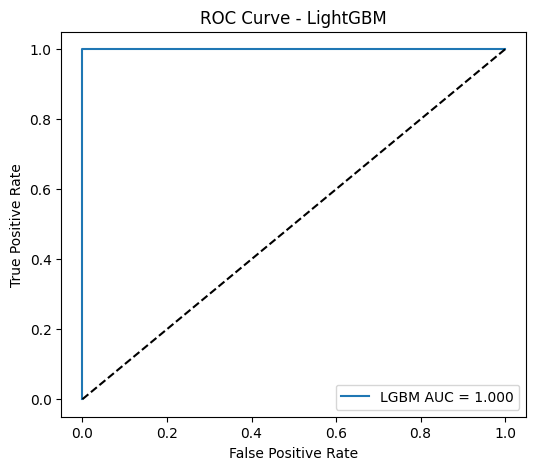

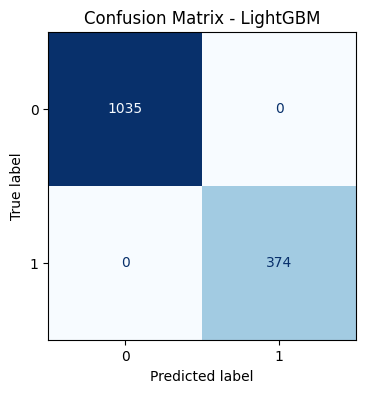

SVC Accuracy: 1.0000

SVC Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



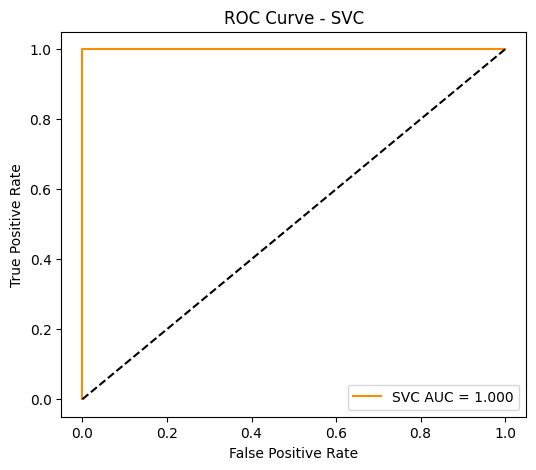

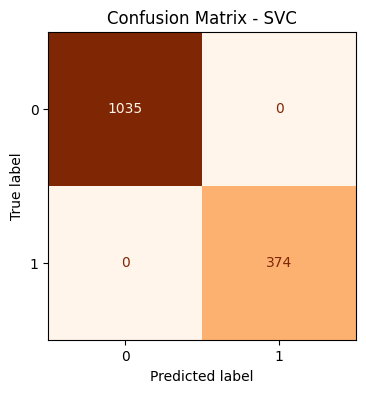


Saved plots:
- roc_lgbm.png
- cm_lgbm.png


NameError: name 'fi_path' is not defined

In [17]:
# Classification: LightGBM + SVC (ROC, Confusion Matrix, Feature Importance)
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.calibration import CalibratedClassifierCV

# Ensure static directory exists for saving plots
static_dir = os.path.join(os.getcwd(), 'static')
os.makedirs(static_dir, exist_ok=True)

# Reuse X, y, and train/test split from preprocessing
# Recreate split safely in case variables were overwritten
X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Align columns and sanitize names (LightGBM-friendly)
X_train_c2 = X_train_c2.loc[:, ~X_train_c2.columns.duplicated()]
X_test_c2 = X_test_c2[X_train_c2.columns]
X_train_c2.columns = X_train_c2.columns.str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
X_test_c2.columns = X_test_c2.columns.str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)

# 1) LightGBM Classifier
lgbm_clf = LGBMClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    verbose=-1
)
lgbm_clf.fit(X_train_c2, y_train_c2)

# Predictions and metrics
lgbm_pred = lgbm_clf.predict(X_test_c2)
lgbm_proba = lgbm_clf.predict_proba(X_test_c2)[:, 1]
acc_lgbm = accuracy_score(y_test_c2, lgbm_pred)
print(f"LightGBM Accuracy: {acc_lgbm:.4f}")
print("\nLightGBM Classification Report:\n", classification_report(y_test_c2, lgbm_pred))

# ROC Curve for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test_c2, lgbm_proba)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
plt.figure(figsize=(6,5))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM AUC = {roc_auc_lgbm:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
roc_lgbm_path = os.path.join(static_dir, 'roc_lgbm.png')
plt.savefig(roc_lgbm_path, bbox_inches='tight')
plt.show()

# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test_c2, lgbm_pred)
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(cm_lgbm).plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix - LightGBM')
cm_lgbm_path = os.path.join(static_dir, 'cm_lgbm.png')
plt.savefig(cm_lgbm_path, bbox_inches='tight')
plt.show()



# 2) SVC with probability for ROC
svc = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
# If calibration is needed, uncomment below lines (kept simple for now)
# svc = CalibratedClassifierCV(SVC(C=1.0, kernel='rbf', probability=False, random_state=42), method='sigmoid')
svc.fit(X_train_c2, y_train_c2)
svc_pred = svc.predict(X_test_c2)
svc_proba = svc.predict_proba(X_test_c2)[:, 1]
acc_svc = accuracy_score(y_test_c2, svc_pred)
print(f"SVC Accuracy: {acc_svc:.4f}")
print("\nSVC Classification Report:\n", classification_report(y_test_c2, svc_pred))

fpr_svc, tpr_svc, _ = roc_curve(y_test_c2, svc_proba)
roc_auc_svc = auc(fpr_svc, tpr_svc)
plt.figure(figsize=(6,5))
plt.plot(fpr_svc, tpr_svc, label=f'SVC AUC = {roc_auc_svc:.3f}', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend(loc='lower right')
roc_svc_path = os.path.join(static_dir, 'roc_svc.png')
plt.savefig(roc_svc_path, bbox_inches='tight')
plt.show()

cm_svc = confusion_matrix(y_test_c2, svc_pred)
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(cm_svc).plot(ax=ax, cmap='Oranges', colorbar=False)
plt.title('Confusion Matrix - SVC')
cm_svc_path = os.path.join(static_dir, 'cm_svc.png')
plt.savefig(cm_svc_path, bbox_inches='tight')
plt.show()

print("\nSaved plots:")
print("-", os.path.basename(roc_lgbm_path))
print("-", os.path.basename(cm_lgbm_path))
print("-", os.path.basename(fi_path))
print("-", os.path.basename(roc_svc_path))
print("-", os.path.basename(cm_svc_path))

# Save metrics for app consumption
analysis_metrics = {
    'classification': {
        'lgbm': {
            'accuracy': float(acc_lgbm),
            'roc_auc': float(roc_auc_lgbm)
        },
        'svc': {
            'accuracy': float(acc_svc),
            'roc_auc': float(roc_auc_svc)
        }
    }
}
metrics_path = os.path.join(os.getcwd(), 'models', 'analysis_metrics.json')
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
import json
with open(metrics_path, 'w') as f:
    json.dump(analysis_metrics, f, indent=2)
print('Saved metrics:', metrics_path)


In [ ]:
# Regression: Faster SVR for Monthly Charges Estimation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, os

print("⚙️ Starting SVR regression (optimized)...")

# Prepare regression dataset
reg_target = 'Monthly Charges'
assert reg_target in df.columns, "Monthly Charges not found in dataset after cleaning."

# Features exclude target and known label columns
reg_exclude = ['Churn Value']
X_reg = df.drop(columns=[c for c in reg_exclude + [reg_target] if c in df.columns]).copy()
y_reg = df[reg_target].astype(float)

# If dataset is large, sample to speed up
if len(X_reg) > 5000:
    print(f"Dataset too large ({len(X_reg)} rows) — sampling 5000 for faster SVR.")
    sample_idx = np.random.choice(X_reg.index, 5000, replace=False)
    X_reg = X_reg.loc[sample_idx]
    y_reg = y_reg.loc[sample_idx]

# Identify categorical and numeric columns
cat_cols_reg = X_reg.select_dtypes(include='object').columns.tolist()
num_cols_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocess_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_reg)
    ]
)

# Smaller C and linear kernel for speed
svr_pipeline = Pipeline([
    ('preprocess', preprocess_reg),
    ('model', SVR(kernel='linear', C=1.0, epsilon=0.2))
])

# Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Fit the model
svr_pipeline.fit(X_train_r, y_train_r)
y_pred_r = svr_pipeline.predict(X_test_r)

# Metrics
rmse = mean_squared_error(y_test_r, y_pred_r, squared=False)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
print(f"✅ SVR Regression - RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

# Plot True vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.6)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
plt.xlabel('True Monthly Charges')
plt.ylabel('Predicted Monthly Charges')
plt.title('SVR: True vs Predicted Monthly Charges (Optimized)')
svr_scatter_path = os.path.join(static_dir, 'regression_svr_true_vs_pred.png')
plt.savefig(svr_scatter_path, bbox_inches='tight')
plt.show()

print("📊 Saved:", os.path.basename(svr_scatter_path))

# Append regression metrics to JSON
try:
    with open(metrics_path, 'r') as f:
        _existing = json.load(f)
except Exception:
    _existing = {}

_existing.setdefault('regression', {})['svr_monthly_charges'] = {
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2)
}

with open(metrics_path, 'w') as f:
    json.dump(_existing, f, indent=2)

print('📁 Updated metrics with regression:', metrics_path)


In [ ]:
# Enhanced KMeans Clustering - Balanced and Visually Clear
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, json

print("⚙️ Starting improved KMeans clustering...")

# 1️⃣ Select key numeric features
candidate_features = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
use_features = [c for c in candidate_features if c in df.columns]

if len(use_features) < 3:
    numeric_df = df.select_dtypes(include=['int64', 'float64']).drop(columns=[c for c in ['Churn Value'] if c in df.columns])
    use_features = numeric_df.var().sort_values(ascending=False).head(3).index.tolist()

assert len(use_features) >= 2, "Not enough numeric features for clustering."

# 2️⃣ Prepare scaled data
X_clust = df[use_features].copy()
X_clust = X_clust.apply(pd.to_numeric, errors='coerce').fillna(X_clust.median(numeric_only=True))
scaler = StandardScaler()
X_clust_scaled = scaler.fit_transform(X_clust)

# 3️⃣ Sampling for large datasets
if X_clust_scaled.shape[0] > 5000:
    idx = np.random.choice(X_clust_scaled.shape[0], 5000, replace=False)
    X_clust_scaled = X_clust_scaled[idx]
    X_clust = X_clust.iloc[idx]

# 4️⃣ Determine optimal k (2–8) using Silhouette
best_k, best_score = 0, -1
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_clust_scaled)
    score = silhouette_score(X_clust_scaled, labels)
    if score > best_score:
        best_k, best_score = k, score

print(f"✅ Optimal number of clusters: k={best_k} (Silhouette Score={best_score:.3f})")

# 5️⃣ Final clustering with optimal k
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=300)
clusters = km_final.fit_predict(X_clust_scaled)

# 6️⃣ Optional PCA for better 2D/3D visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_clust_scaled)

# 7️⃣ Plot 2D (PC1 vs PC2)
plt.figure(figsize=(7,5))
palette = sns.color_palette("tab10", best_k)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette=palette, s=35, alpha=0.8, edgecolor='none')
plt.title(f"KMeans Clusters (k={best_k}) - PCA 2D View")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
k2d_path = os.path.join(static_dir, 'kmeans_2d.png')
plt.savefig(k2d_path, bbox_inches='tight')
plt.show()

# 8️⃣ 3D Scatter for richer view
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=clusters, cmap='tab10', s=20, alpha=0.8)
ax.set_title(f"KMeans Clusters (k={best_k}) - 3D PCA View")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
k3d_path = os.path.join(static_dir, 'kmeans_3d.png')
plt.savefig(k3d_path, bbox_inches='tight')
plt.show()

print("✅ Saved:", os.path.basename(k2d_path))
print("✅ Saved:", os.path.basename(k3d_path))

# 9️⃣ Update metrics JSON
try:
    with open(metrics_path, 'r') as f:
        _existing = json.load(f)
except Exception:
    _existing = {}

_existing.setdefault('clustering', {})['kmeans'] = {
    'k': int(best_k),
    'silhouette_score': float(best_score),
    'features_used': use_features,
    'rows_used': int(X_clust.shape[0])
}

with open(metrics_path, 'w') as f:
    json.dump(_existing, f, indent=2)

print('📁 Updated metrics with clustering:', metrics_path)
